# Random forest implementation

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Load and Inspect Your Prepared Data
print("Step 1: Loading and inspecting prepared data...")
print("=" * 50)

# Load the datasets
train_df = pd.read_csv("../Dataset/train_data_for_modeling(no_standardization).csv")
test_df = pd.read_csv("../Dataset/test_data_for_modeling.csv")

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Check structure
print("\nTraining data info:")
train_df.info()

print("\nTraining data description:")
print(train_df.describe())

# Identify target variable and features
target_col = "LOG_RESALE_PRICE"

feature_cols = [col for col in train_df.columns if col not in [target_col, "RESALE_PRICE"]]

print(f"\nTarget variable: {target_col}")
print(f"Number of features: {len(feature_cols)}")
print(f"First 10 features: {feature_cols[:10]}")




Step 1: Loading and inspecting prepared data...
Training data shape: (162570, 89)
Test data shape: (50000, 87)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162570 entries, 0 to 162569
Data columns (total 89 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   FLOOR_AREA_SQM                     162570 non-null  float64
 1   RESALE_PRICE                       162570 non-null  float64
 2   LOG_RESALE_PRICE                   162570 non-null  float64
 3   TRANSACTION_YEAR                   162570 non-null  int64  
 4   TRANSACTION_MONTH                  162570 non-null  int64  
 5   REMAINING_AGE                      162570 non-null  int64  
 6   FLOOR_LEVEL_MID                    162570 non-null  float64
 7   FLAT_TYPE_ENCODED                  162570 non-null  float64
 8   FLAT_MODEL_2 room                  162570 non-null  float64
 9   FLAT_MODEL_3gen                    16

In [2]:
# Step 2: Split the Training Set into Train/Validation Sets
print("\n\nStep 2: Splitting training data into train/validation sets...")
print("=" * 50)

X = train_df[feature_cols]
y = train_df[target_col]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Feature dimensions: {X_train.shape[1]}")
print(f"Training on LOG_RESALE_PRICE, will convert predictions back to original scale for evaluation")





Step 2: Splitting training data into train/validation sets...
Training set size: 130056
Validation set size: 32514
Feature dimensions: 87
Training on LOG_RESALE_PRICE, will convert predictions back to original scale for evaluation


In [3]:
# Step 3: Train a Baseline Random Forest Model
print("\n\nStep 3: Training baseline Random Forest model...")
print("=" * 50)

rf_baseline = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

print("Baseline Random Forest model trained successfully!")





Step 3: Training baseline Random Forest model...
Baseline Random Forest model trained successfully!


In [4]:
# Step 4: Evaluate Baseline Model
print("\n\nStep 4: Evaluating baseline model...")
print("=" * 50)

y_pred_baseline_log = rf_baseline.predict(X_val)
y_pred_baseline = np.exp(y_pred_baseline_log)

y_val_original = np.exp(y_val)

mae_baseline = mean_absolute_error(y_val_original, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_val_original, y_pred_baseline))
r2_baseline = r2_score(y_val_original, y_pred_baseline)

print(f"Baseline Model Performance")
print(f"MAE: ${mae_baseline:,.2f}")
print(f"RMSE: ${rmse_baseline:,.2f}")
print(f"R²: {r2_baseline:.4f}")





Step 4: Evaluating baseline model...
Baseline Model Performance
MAE: $23,202.36
RMSE: $34,282.04
R²: 0.9647


In [5]:
# Step 5: Hyperparameter Tuning (Model Optimization)
print("\n\nStep 5: Hyperparameter tuning...")
print("=" * 50)

# Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500], # number of trees in the forest
    'max_depth': [10, 20, 30, None], # maximum depth of the tree
    'min_samples_split': [2, 5, 10], # minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4], # minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None] # number of features to consider at each split
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
search = RandomizedSearchCV(
    rf, 
    param_grid, 
    scoring='neg_mean_absolute_error', 
    cv=3, # number of folds in cross-validation, train model n times for each parameter setting
    n_iter=30, # number of parameter settings that are sampled
    n_jobs=-1, # number of cores to use for parallel processing
    random_state=42,
    verbose=1
)

print("Starting hyperparameter search...")
search.fit(X_train, y_train)

best_rf = search.best_estimator_
print(f"\nBest parameters: {search.best_params_}")
print(f"Best cross-validation score: ${-search.best_score_:,.2f}")





Step 5: Hyperparameter tuning...
Starting hyperparameter search...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}
Best cross-validation score: $0.05


MAE=​∑∣ytrue​−ypred​∣/n

RMSE=sqrt(∑(ytrue​−ypred​)2/n)
​


In [6]:
# Step 6: Evaluate the Tuned Model
print("\n\nStep 6: Evaluating tuned model...")
print("=" * 50)

y_pred_tuned_log = best_rf.predict(X_val)
y_pred_tuned = np.exp(y_pred_tuned_log)

mae_tuned = mean_absolute_error(y_val_original, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_val_original, y_pred_tuned))
r2_tuned = r2_score(y_val_original, y_pred_tuned)

print(f"Tuned Model Performance:")
print(f"MAE: ${mae_tuned:,.2f}")
print(f"RMSE: ${rmse_tuned:,.2f}")
print(f"R²: {r2_tuned:.4f}")

print(f"\nImprovement over baseline:")
print(f"MAE improvement: ${mae_baseline - mae_tuned:,.2f} ({((mae_baseline - mae_tuned) / mae_baseline * 100):.1f}%)")
print(f"RMSE improvement: ${rmse_baseline - rmse_tuned:,.2f} ({((rmse_baseline - rmse_tuned) / rmse_baseline * 100):.1f}%)")
print(f"R² improvement: {r2_tuned - r2_baseline:.3f}")







Step 6: Evaluating tuned model...
Tuned Model Performance:
MAE: $23,167.78
RMSE: $34,298.21
R²: 0.9647

Improvement over baseline:
MAE improvement: $34.57 (0.1%)
RMSE improvement: $-16.18 (-0.0%)
R² improvement: -0.000




Step 7: Feature importance analysis...
Top 15 most important features:
 1. GEO_AVG_PRICE_K16             : 0.5230
 2. FLOOR_AREA_SQM                : 0.1585
 3. TRANSACTION_YEAR              : 0.1534
 4. FLAT_TYPE_ENCODED             : 0.0554
 5. REMAINING_AGE                 : 0.0142
 6. LATITUDE                      : 0.0124
 7. FLOOR_LEVEL_MID               : 0.0080
 8. LONGITUDE                     : 0.0079
 9. GEO_AVG_PRICE_K128            : 0.0066
10. FLOOR_LEVEL_RATIO             : 0.0065
11. HAWKER_COUNT_3.0KM            : 0.0054
12. GEO_STD_PRICE_K16             : 0.0042
13. MAX_FLOOR                     : 0.0036
14. TRANSACTION_MONTH             : 0.0034
15. GEO_AVG_PRICE_K64             : 0.0033


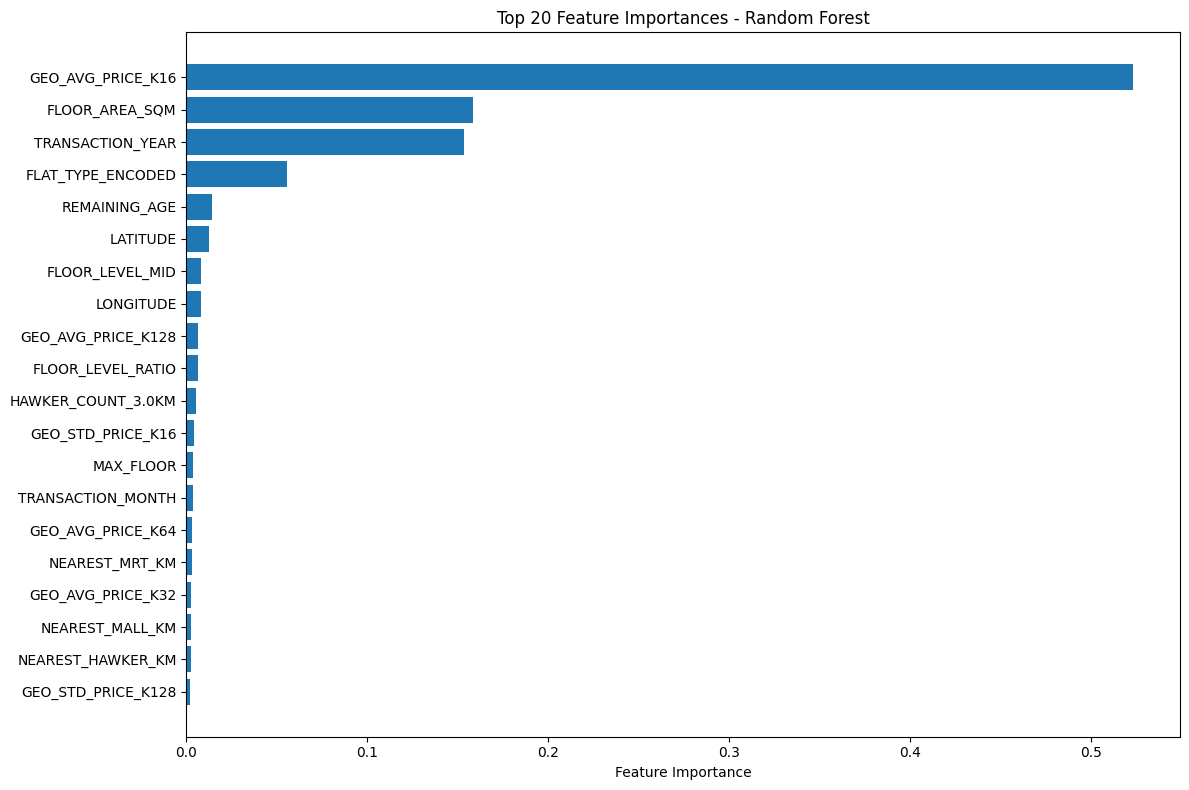

In [7]:
# Step 7: Feature Importance Analysis
print("\n\nStep 7: Feature importance analysis...")
print("=" * 50)

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Top 15 most important features:")
for i in range(min(15, len(feature_cols))):
    print(f"{i+1:2d}. {X_train.columns[indices[i]]:<30}: {importances[indices[i]]:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 8))
top_n = min(20, len(feature_cols))
plt.barh(range(top_n), importances[indices[:top_n]])
plt.yticks(range(top_n), [X_train.columns[indices[i]] for i in range(top_n)])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Feature Importances - Random Forest")
plt.tight_layout()
plt.show()



In [8]:
# Step 8: Test on the Held-out Test Set
print("\n\nStep 8: Testing on held-out test set...")
print("=" * 50)

# Check if test set has target variable
if target_col in test_df.columns:

    X_test = test_df[feature_cols]
    y_test = test_df[target_col]
    
    y_test_pred_log = best_rf.predict(X_test)
    y_test_pred = np.exp(y_test_pred_log)
    

    y_test_original = np.exp(y_test)
    
    mae_test = mean_absolute_error(y_test_original, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_original, y_test_pred))
    r2_test = r2_score(y_test_original, y_test_pred)
    
    print(f"Test Set Performance (在原始价格空间评估):")
    print(f"MAE: ${mae_test:,.2f}")
    print(f"RMSE: ${rmse_test:,.2f}")
    print(f"R²: {r2_test:.4f}")
    
    # Plot test predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_original, y_test_pred, alpha=0.5, color='purple')
    plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title(f"Test Set: Predicted vs Actual\nR² = {r2_test:.4f}")
    plt.ticklabel_format(style='plain', axis='both')
    plt.show()
    
else:
    print("Test set does not contain target variable. Making predictions...")
    X_test = test_df[[col for col in feature_cols if col in test_df.columns]]
    
    predictions_log = best_rf.predict(X_test)
    predictions = np.exp(predictions_log)
    
    # Save predictions
    submission = pd.DataFrame({"predicted_resale_price": predictions})
    submission.to_csv("../Results/rf_predictions.csv", index=False)
    print("Predictions saved to '../Results/rf_predictions.csv'")
    
    print(f"Prediction statistics:")
    print(f"Mean predicted price: ${predictions.mean():,.2f}")
    print(f"Median predicted price: ${np.median(predictions):,.2f}")
    print(f"Min predicted price: ${predictions.min():,.2f}")
    print(f"Max predicted price: ${predictions.max():,.2f}")

# Step 9: Model Summary and Analysis
print("\n\nStep 9: Model Summary and Analysis")
print("=" * 50)

print("\nModel Performance Summary:")
print(f"{'Metric':<15} {'Baseline':<15} {'Tuned':<15} {'Improvement':<15}")
print("-" * 60)
print(f"{'MAE':<15} ${mae_baseline:<14,.0f} ${mae_tuned:<14,.0f} ${mae_baseline-mae_tuned:<14,.0f}")
print(f"{'RMSE':<15} ${rmse_baseline:<14,.0f} ${rmse_tuned:<14,.0f} ${rmse_baseline-rmse_tuned:<14,.0f}")
print(f"{'R²':<15} {r2_baseline:<15.3f} {r2_tuned:<15.3f} {r2_tuned-r2_baseline:<15.3f}")

print(f"\nFinal Model Parameters:")
for param, value in best_rf.get_params().items():
    if param in param_grid:
        print(f"  {param}: {value}")

print(f"\nKey Insights:")
print(f"1. The Random Forest model explains {r2_tuned:.1%} of the variance in HDB resale prices")
print(f"2. Average prediction error is approximately ${mae_tuned:,.0f}")
print(f"3. Model trained on LOG_RESALE_PRICE and predictions converted back to original scale")
print(f"4. Top 3 most important features:")
for i in range(3):
    print(f"   - {X_train.columns[indices[i]]}: {importances[indices[i]]:.3f}")

print(f"\nModel Limitations and Considerations:")
print(f"- Model performance may vary across different flat types, locations, or time periods")
print(f"- Feature importance reflects correlation, not necessarily causation")
print(f"- Model assumes relationships in training data will hold for future predictions")
print(f"- RESALE_PRICE and LOG_RESALE_PRICE excluded from features to avoid data leakage")
print(f"- Consider ensemble methods or gradient boosting for potential improvements")



Step 8: Testing on held-out test set...
Test set does not contain target variable. Making predictions...
Predictions saved to '../Results/rf_predictions.csv'
Prediction statistics:
Mean predicted price: $214,628.03
Median predicted price: $217,280.92
Min predicted price: $193,632.00
Max predicted price: $228,827.14


Step 9: Model Summary and Analysis

Model Performance Summary:
Metric          Baseline        Tuned           Improvement    
------------------------------------------------------------
MAE             $23,202         $23,168         $35            
RMSE            $34,282         $34,298         $-16           
R²              0.965           0.965           -0.000         

Final Model Parameters:
  max_depth: None
  max_features: None
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 300

Key Insights:
1. The Random Forest model explains 96.5% of the variance in HDB resale prices
2. Average prediction error is approximately $23,168
3. Model trained on LOG

 Optimzation
1. Used HalvingRandomSearchCV for efficient hyperparameter tuning
2. Trained on 20% sample (26,011 observations) for speed
4. use Using top 15 features to train, reduce model complexity 

In [9]:
import time

# Step 10: Advanced Optimization with HalvingRandomSearchCV
print("\n\nStep 10: Advanced Optimization with HalvingRandomSearchCV")
print("=" * 60)

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# Use the top 15 most important features based on the analysis
top_15_feature_names = [
    'GEO_AVG_PRICE_K16',
    'FLOOR_AREA_SQM',
    'TRANSACTION_YEAR',
    'FLAT_TYPE_ENCODED',
    'REMAINING_AGE',
    'LATITUDE',
    'FLOOR_LEVEL_MID',
    'LONGITUDE',
    'GEO_AVG_PRICE_K128',
    'FLOOR_LEVEL_RATIO',
    'HAWKER_COUNT_3.0KM',
    'GEO_STD_PRICE_K16',
    'MAX_FLOOR',
    'TRANSACTION_MONTH',
    'GEO_AVG_PRICE_K64'
]

print(f"Using top 15 features for optimization:")
for i, feature in enumerate(top_15_feature_names):
    print(f"  {i+1:2d}. {feature}")

# Select only the top 15 features that exist in the training data
available_top15_features = [col for col in top_15_feature_names if col in X_train.columns]
print(f"\nAvailable features in training data: {len(available_top15_features)}")

X_train_top15 = X_train[available_top15_features]
X_val_top15 = X_val[available_top15_features]

# Sample 20% of training data for faster hyperparameter tuning
print(f"\nUsing 80% sample of training data for hyperparameter tuning...")
X_sample = X_train_top15.sample(frac=0.8, random_state=42)
y_sample = y_train.loc[X_sample.index]
print(f"Sample size: {len(X_sample):,} observations")



# Define parameter grid for HalvingRandomSearchCV
param_grid_halving = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20,30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize HalvingRandomSearchCV
print(f"\nInitializing HalvingRandomSearchCV...")
halving_search = HalvingRandomSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_halving,
    factor=2,  # Reduction factor for each iteration
    resource='n_samples',  # Use number of samples as resource
    max_resources='auto',  # Use all available samples in final iteration
    min_resources=200,  # Minimum number of samples to use
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the halving search on sample data
print(f"Fitting HalvingRandomSearchCV on sample data...")
start_time = time.time()
halving_search.fit(X_sample, y_sample)
halving_time = time.time() - start_time

print(f"HalvingRandomSearchCV completed in {halving_time:.2f} seconds")
print(f"Best parameters found:")
for param, value in halving_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Best cross-validation MAE: ${-halving_search.best_score_:,.0f}")

# Train final model with best parameters on full training set (top 15 features)
print(f"\nTraining final optimized model on full training set with top 15 features...")
best_rf_optimized = RandomForestRegressor(**halving_search.best_params_, random_state=42, n_jobs=-1)
best_rf_optimized.fit(X_train_top15, y_train)

# Make predictions on validation set
y_val_pred_optimized_log = best_rf_optimized.predict(X_val_top15)


y_val_pred_optimized = np.exp(y_val_pred_optimized_log)
y_val_original = np.exp(y_val)

# Calculate metrics for optimized model
mae_optimized = mean_absolute_error(y_val_original, y_val_pred_optimized)
rmse_optimized = np.sqrt(mean_squared_error(y_val_original, y_val_pred_optimized))
r2_optimized = r2_score(y_val_original, y_val_pred_optimized)

print(f"\nOptimized Model Performance (Top 15 Features) :")
print(f"MAE: ${mae_optimized:,.2f}")
print(f"RMSE: ${rmse_optimized:,.2f}")
print(f"R²: {r2_optimized:.4f}")

# Compare all models
print(f"\nModel Comparison Summary :")
print(f"{'Model':<25} {'Features':<10} {'MAE':<18} {'RMSE':<18} {'R²':<10}")
print("-" * 80)
print(f"{'Baseline RF':<25} {'All':<10} ${mae_baseline:<17,.2f} ${rmse_baseline:<17,.2f} {r2_baseline:<10.4f}")
print(f"{'Tuned RF':<25} {'All':<10} ${mae_tuned:<17,.2f} ${rmse_tuned:<17,.2f} {r2_tuned:<10.4f}")
print(f"{'Optimized RF (Top 15)':<25} {'Top 15':<10} ${mae_optimized:<17,.2f} ${rmse_optimized:<17,.2f} {r2_optimized:<10.4f}")

# Generate final predictions on test set
print(f"\nGenerating final predictions on test set...")
test_df_top15 = test_df[[col for col in available_top15_features if col in test_df.columns]]


predictions_log_optimized = best_rf_optimized.predict(test_df_top15)
predictions_optimized = np.exp(predictions_log_optimized)

# Save optimized predictions
submission_optimized = pd.DataFrame({"predicted_resale_price": predictions_optimized})
submission_optimized.to_csv("../Results/rf_predictions_optimized.csv", index=False)
print("Optimized predictions saved to '../Results/rf_predictions_optimized.csv'")





Step 10: Advanced Optimization with HalvingRandomSearchCV
Using top 15 features for optimization:
   1. GEO_AVG_PRICE_K16
   2. FLOOR_AREA_SQM
   3. TRANSACTION_YEAR
   4. FLAT_TYPE_ENCODED
   5. REMAINING_AGE
   6. LATITUDE
   7. FLOOR_LEVEL_MID
   8. LONGITUDE
   9. GEO_AVG_PRICE_K128
  10. FLOOR_LEVEL_RATIO
  11. HAWKER_COUNT_3.0KM
  12. GEO_STD_PRICE_K16
  13. MAX_FLOOR
  14. TRANSACTION_MONTH
  15. GEO_AVG_PRICE_K64

Available features in training data: 15

Using 80% sample of training data for hyperparameter tuning...
Sample size: 104,045 observations

Initializing HalvingRandomSearchCV...
Fitting HalvingRandomSearchCV on sample data...
n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 10
min_resources_: 200
max_resources_: 104045
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 520
n_resources: 200
Fitting 3 folds for each of 520 candidates, totalling 1560 fits
----------
iter: 1
n_candidates: 260
n_resources: 400
Fitting 3 folds for eac

In [10]:
# Fix the submission format for optimized predictions
print(f"\nFixing submission format for optimized predictions...")

# Create Id column with incremental values starting from 0
num_predictions = len(predictions_optimized)
test_ids = range(num_predictions)

# Create properly formatted submission
submission_optimized_fixed = pd.DataFrame({
    "Id": test_ids,
    "Predicted": predictions_optimized
})

# Save the corrected submission
submission_optimized_fixed.to_csv("../Results/rf_predictions_optimized.csv", index=False)
print("Fixed optimized predictions saved to '../Results/rf_predictions_optimized.csv'")

# Display first few rows to verify format
print(f"\nSubmission format preview:")
print(submission_optimized_fixed.head())




Fixing submission format for optimized predictions...
Fixed optimized predictions saved to '../Results/rf_predictions_optimized.csv'

Submission format preview:
   Id      Predicted
0   0  226186.137000
1   1  282670.783128
2   2  230890.493477
3   3  282927.247687
4   4  283130.944786
